In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import balanced_accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score, make_scorer
import plotly.express as px
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost  import XGBClassifier

In [2]:
trans_df = pd.read_csv("/kaggle/input/fraud-dataset/Fraud.csv")
trans_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
#getting dataset information
trans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [4]:
trans_df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [5]:
trans_df.shape

(6362620, 11)

In [6]:
trans_df.type.value_counts()

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

In [7]:
indexe_ = trans_df.type.value_counts().index
value_ = trans_df.type.value_counts().values

px.pie(trans_df,values=value_,names=indexe_,title='Distribution of transaction type')

In [8]:
trans_df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [9]:
numerical_attr = trans_df.select_dtypes(exclude='object')

In [10]:
#statistical analysis of numerical attributes
numerical_attr.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [11]:
#checking for correlation between the attributes
numerical_attr.corr()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
step,1.000000,0.022373,-0.010058,-0.010299,0.027665,0.025888,0.031578,0.003277
amount,0.022373,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.076688,0.012295
oldbalanceOrg,-0.010058,-0.002762,1.000000,0.998803,0.066243,0.042029,0.010154,0.003835
newbalanceOrig,-0.010299,-0.007861,0.998803,1.000000,0.067812,0.041837,-0.008148,0.003776
oldbalanceDest,0.027665,0.294137,0.066243,0.067812,1.000000,0.976569,-0.005885,-0.000513
newbalanceDest,0.025888,0.459304,0.042029,0.041837,0.976569,1.000000,0.000535,-0.000529
isFraud,0.031578,0.076688,0.010154,-0.008148,-0.005885,0.000535,1.000000,0.044109
isFlaggedFraud,0.003277,0.012295,0.003835,0.003776,-0.000513,-0.000529,0.044109,1.000000


In [12]:
numerical_attr.skew() 

step                0.375177
amount             30.993949
oldbalanceOrg       5.249136
newbalanceOrig      5.176884
oldbalanceDest     19.921758
newbalanceDest     19.352302
isFraud            27.779538
isFlaggedFraud    630.603629
dtype: float64

In [13]:
from scipy.special import boxcox1p 

skew_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
df_logs = trans_df[skew_cols]
df_boxcox = trans_df[skew_cols]
for i in skew_cols: 
    df_logs.loc[:,i] = np.log(df_logs[i]+1)
    df_boxcox.loc[:,i] = boxcox1p(df_boxcox[i], 0.1)

In [14]:
df_logs.skew()

amount           -0.555018
oldbalanceOrg    -0.259723
newbalanceOrig    0.440148
oldbalanceDest   -0.213261
newbalanceDest   -0.386937
dtype: float64

In [15]:
df_boxcox.skew() 

amount           -0.076000
oldbalanceOrg     0.342407
newbalanceOrig    0.741744
oldbalanceDest   -0.040291
newbalanceDest   -0.201477
dtype: float64

In [16]:
df = pd.concat([trans_df[['step','type','nameOrig', 'nameDest','isFraud', 'isFlaggedFraud']],df_logs[['oldbalanceOrg','newbalanceOrig']], df_boxcox[['amount','oldbalanceDest','newbalanceDest']]], axis=1, join='inner') 
print(df.shape)
df.head()

(6362620, 11)


,step,type,nameOrig,nameDest,isFraud,isFlaggedFraud,oldbalanceOrg,newbalanceOrig,amount,oldbalanceDest,newbalanceDest
0,1,PAYMENT,C1231006815,M1979787155,0,0,12.044359,11.984786,15.078545,0.000000,0.0
1,1,PAYMENT,C1666544295,M2044282225,0,0,9.964112,9.872292,11.236082,0.000000,0.0
2,1,TRANSFER,C1305486145,C553264065,1,0,5.204007,0.000000,6.827017,0.000000,0.0
3,1,CASH_OUT,C840083671,C38997010,1,0,5.204007,0.000000,6.827017,17.076888,0.0
4,1,PAYMENT,C2048537720,M1230701703,0,0,10.634773,10.305174,15.509614,0.000000,0.0


In [17]:
df[df.isFraud == 1].tail(30)

,step,type,nameOrig,nameDest,isFraud,isFlaggedFraud,oldbalanceOrg,newbalanceOrig,amount,oldbalanceDest,newbalanceDest
6362590,741,TRANSFER,C509686434,C1310143791,1,0,12.687658,0.0,25.564604,0.000000,0.000000
6362591,741,CASH_OUT,C919525792,C993635374,1,0,12.687658,0.0,25.564604,27.579817,29.329456
6362592,741,TRANSFER,C457476945,C1688658215,1,0,12.857517,0.0,26.173863,0.000000,0.000000
6362593,741,CASH_OUT,C369315575,C2069429837,1,0,12.857517,0.0,26.173863,32.192913,33.021097
6362594,741,TRANSFER,C31496887,C1251365829,1,0,11.884119,0.0,22.818651,0.000000,0.000000
6362595,741,CASH_OUT,C1092829426,C716019997,1,0,11.884119,0.0,22.818651,0.000000,22.818651
6362596,741,TRANSFER,C1112979339,C2114078084,1,0,10.788161,0.0,19.411955,0.000000,0.000000
6362597,741,CASH_OUT,C1706094385,C2109905271,1,0,10.788161,0.0,19.411955,27.245598,27.582729
6362598,742,TRANSFER,C1044665079,C750074708,1,0,15.204067,0.0,35.740852,0.000000,0.000000
6362599,742,CASH_OUT,C1970706589,C637394241,1,0,15.204067,0.0,35.740852,30.642662,36.981119


In [18]:
import re  
df['nameOrig'] = df['nameOrig'].apply(lambda x: re.sub('C[A-Za-z0-9]*', 'C',x)) 
df['nameDest'] = df['nameDest'].apply(lambda x: re.sub('C[A-Za-z0-9]*','C',x))   
df['nameDest'] = df['nameDest'].apply(lambda x: re.sub('M[A-Za-z0-9]*','M',x)) 
df.head()

,step,type,nameOrig,nameDest,isFraud,isFlaggedFraud,oldbalanceOrg,newbalanceOrig,amount,oldbalanceDest,newbalanceDest
0,1,PAYMENT,C,M,0,0,12.044359,11.984786,15.078545,0.000000,0.0
1,1,PAYMENT,C,M,0,0,9.964112,9.872292,11.236082,0.000000,0.0
2,1,TRANSFER,C,C,1,0,5.204007,0.000000,6.827017,0.000000,0.0
3,1,CASH_OUT,C,C,1,0,5.204007,0.000000,6.827017,17.076888,0.0
4,1,PAYMENT,C,M,0,0,10.634773,10.305174,15.509614,0.000000,0.0


In [19]:
df[df.isFraud == 1].type.value_counts()

type
CASH_OUT    4116
TRANSFER    4097
Name: count, dtype: int64

In [20]:
from sklearn import preprocessing 
ohe = preprocessing.OneHotEncoder()                                       
df= pd.get_dummies(df, columns=['type','nameOrig', 'nameDest'])
df.head(3)

,step,isFraud,isFlaggedFraud,oldbalanceOrg,newbalanceOrig,amount,oldbalanceDest,newbalanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,nameOrig_C,nameDest_C,nameDest_M
0,1,0,0,12.044359,11.984786,15.078545,0.0,0.0,False,False,False,True,False,True,False,True
1,1,0,0,9.964112,9.872292,11.236082,0.0,0.0,False,False,False,True,False,True,False,True
2,1,1,0,5.204007,0.000000,6.827017,0.0,0.0,False,False,False,False,True,True,True,False


In [21]:
features = ['step', 'isFlaggedFraud', 'oldbalanceOrg', 'newbalanceOrig',
       'amount', 'oldbalanceDest', 'newbalanceDest', 'type_CASH_IN',
       'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER',
       'nameOrig_C', 'nameDest_C', 'nameDest_M']  
target=['isFraud'] 

x_train, x_test, y_train, y_test = train_test_split(df[features],df['isFraud'], test_size=0.2, random_state=42)

In [22]:
len(x_train), len(x_test)

(5090096, 1272524)

In [23]:
y_test.value_counts() 

isFraud
0    1270904
1       1620
Name: count, dtype: int64

In [24]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE 
from imblearn.pipeline import Pipeline
from collections import Counter 
over = SMOTE(sampling_strategy=0.025) 
under=RandomUnderSampler(random_state=42, sampling_strategy=0.5)
steps = [('o', over),('u', under)] 
pipeline = Pipeline(steps=steps) 
x_res, y_res = pipeline.fit_resample(x_train[features], y_train) 
print(Counter(y_res))

Counter({0: 254174, 1: 127087})


In [25]:
def Model_scores(model_name, y_true, y_pred):
    accuracy = balanced_accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    return pd.DataFrame({'Balanced Accuracy': np.round(accuracy, 4), 
                         'Precision': np.round(precision, 4), 
                         'Recall': np.round(recall, 4),
                         'F1': np.round(f1, 4)},
                        index=[model_name])

In [26]:
Rf = RandomForestClassifier(class_weight='balanced', n_estimators=100, n_jobs=-1)
Rf.fit(x_train,y_train)
y_predict = Rf.predict(x_test)

Model_scores('Random Forest',y_test,y_predict)

,Balanced Accuracy,Precision,Recall,F1
Random Forest,0.8886,0.9859,0.7772,0.8692


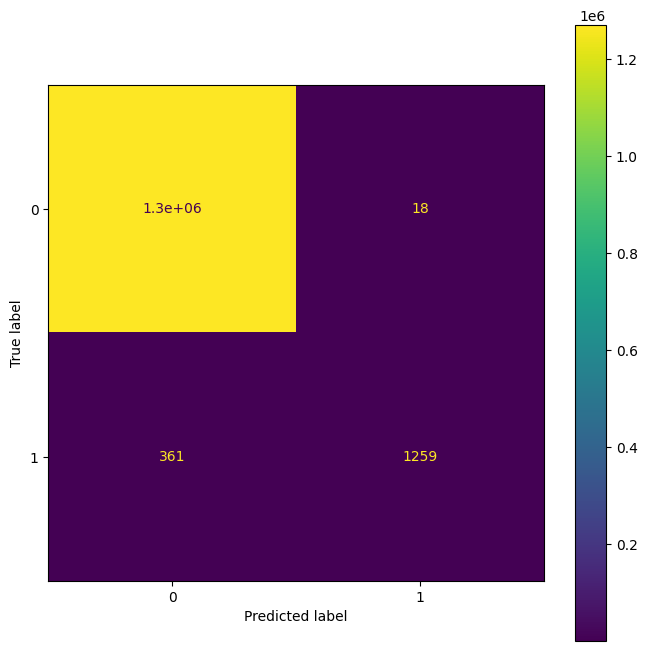

In [27]:
fig, ax = plt.subplots(figsize = (8,8))
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_true = y_test,y_pred = y_predict, ax=ax);

In [28]:
Lr = LogisticRegression(C=0.20433597178569418, solver = "liblinear")
Lr.fit(x_train,y_train)
y_predict = Lr.predict(x_test)

Model_scores('Logistic Regression',y_test,y_predict)

,Balanced Accuracy,Precision,Recall,F1
Logistic Regression,0.7512,0.9335,0.5025,0.6533


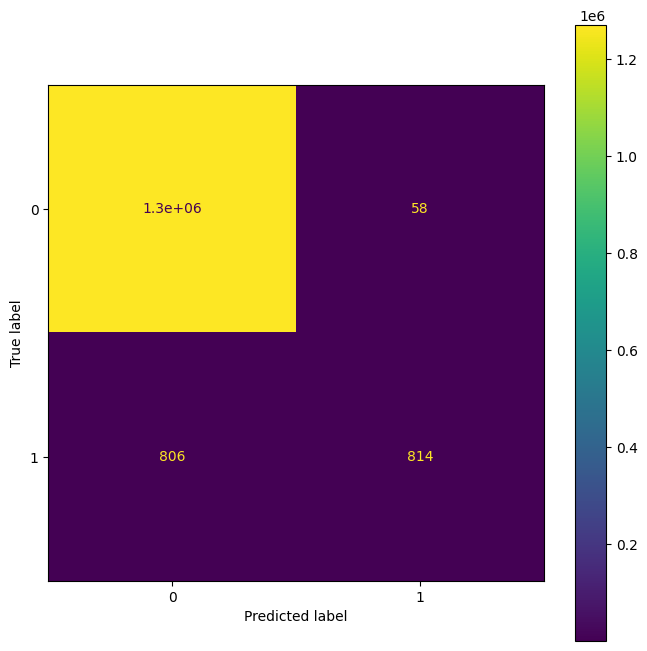

In [29]:
fig, ax = plt.subplots(figsize = (8,8))
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_true = y_test,y_pred = y_predict, ax=ax);